In [86]:
from IPython.display import SVG

import numpy as np
import sklearn as sk
import pandas as pa
import keras
import scipy as sp
import scipy.misc as spm
import scipy.ndimage as spi
import matplotlib.pyplot as plt
import seaborn as sns
import requests
#import h5py

from PIL import Image

from StringIO import StringIO

%matplotlib inline

![Example Perceptron](imgs/tiger_dog.jpg)

Let's say we want a machine learning model capable of telling us this image contains a tiger and a dog. How might we approach this?

<h1>Neural Networks</h1>

Neural networks are currently the state of the art in computer vision, speech recognition, and natural language processing. Today we’ll do a quick overview of the history of neural networks, from their inception to modern deep learning.

![Example Perceptron](imgs/perceptron.png)

The elementary unit of a neural network is the perceptron, an abstract and simplistic model of the process of information transfer used by neurons in the mammalian brain. Each unit of a neural network consists of a number of inputs. In the case of a simple single layer model each input is a feature of your data set. Each input is assigned a weight value. The sum of the incoming values multiplied by their weights, plus a bias value, is passed to an output function. In the case of a simple perceptron, the output function is the step function. This yields the unit’s output.

The original perceptron was implemented in hardware, and the weights were fine tuned by hand. For reasons we'll get to shortly, a single layer perceptron proved incapable of image recognition.

![Mk1 Perceptron](imgs/mk1-perceptron.jpg)

In software implementations, the weights and biases of each unit are incrementally updated to reduce the error of the network's output using standard techniques like Stochastic Gradient Descent (SGD).

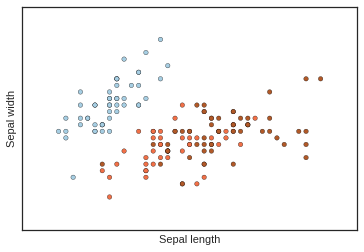

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import make_pipeline

#The iris data set is an example of a linearly separable problem the perceptron can partially learn

scaler = StandardScaler()
perceptron = Perceptron()

#Load Iris data set
iris = sk.datasets.load_iris()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [88]:
# Build and train model

pipeline = sk.pipeline.make_pipeline(scaler, perceptron)

scores = sk.cross_validation.cross_val_score(pipeline, iris.data, iris.target)
print("Iris Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

X = iris.data[:, :2]  # Visualizing the first two features, from the SKLearn documentation
Y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

Iris Accuracy: 0.86 (+/- 0.17)


In the late 60's, it was proven that the single layer perceptron could not learn the simple XOR function, amongst others:

![XOR Tables](imgs/xor-table.png)

The single layer perceptron is equivalent to logistic regression, and as such can only solve linearly separable problems. It could not be a universal approximator, and for ten years little research was performed with neural networks.

In [94]:
# Now to generate an XOR dataset:
X = np.random.randint(0,2,(1000,2))
X = X.astype(np.float64)
y = X[:,0] == X[:,1]

scores = sk.cross_validation.cross_val_score(pipeline, X, y)
print("XOR Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

XOR Accuracy: 0.59 (+/- 0.28)


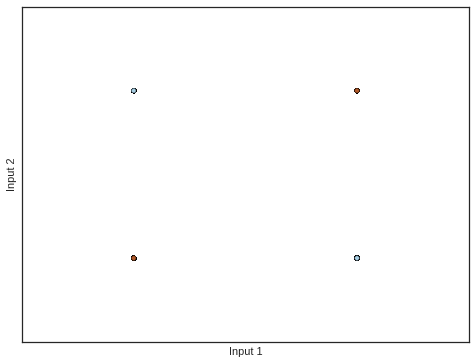

In [95]:
# Plotting the XOR data:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Input 1')
plt.ylabel('Input 2')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Multi-layer perceptrons (MLP), however, are universal approximators. The addition of one or more intermediate layers, each taking the feed-forward output of the previous layer as input, can, given enough nodes and a comprehensive enough training set, theoretically learn any arbitrary function. MLPs did not see practical use until the development of backpropagation, a system of credit assignment that allows error in the final output layer to propagate back to update all weights responsible for that error, allowing multiple layers to be trained in concert.

<img src="imgs/mlp.png" alt="Multilayer Perceptron" style="width: 500px;"/>

Here's an example using a simple MLP to classify the MNIST handwritten digits dataset:

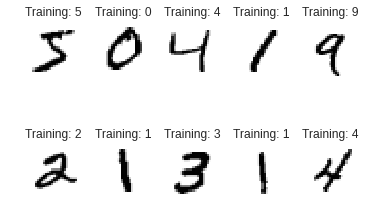

In [96]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils
from keras.utils.visualize_util import to_graph

# Load full MNIST data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Plot some examples
images_and_labels = list(zip(X_train, y_train))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [97]:
# Set some initial parameters
batch_size = 128 # Number of examples to train on in each batch
nb_classes = 10 # Number of classes
nb_epoch = 24 # Number of passses to make over the training data set. Tradeoff between accuracy and overfitting.
img_rows, img_cols = 28, 28 # Image dimensions
    
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

('X_train shape:', (60000, 784))
(60000, 'train samples')
(10000, 'test samples')


In [98]:
model = Sequential()

# Dense(64) is a fully-connected layer with 64 hidden units.
# We expect a 784 element vector because our image is 28x28=784
# We'll initialze the weights to a smaple from a uniform distribution
model.add(Dense(64, input_dim=(784), init='uniform'))
#The layer's activation function
model.add(Activation('tanh'))

model.add(Dense(64, init='uniform'))
model.add(Activation('tanh'))

#The final layer, with one node for each class
model.add(Dense(10, init='uniform'))
model.add(Activation('softmax'))

#Use Stochastic Gradient Descent to learn the weights
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd)

history = model.fit(X_train, Y_train, nb_epoch=nb_epoch,
          batch_size=batch_size, verbose=0,
          show_accuracy=True, validation_split=0.1)

acc = history.history['acc']
val = history.history['val_acc']

Let's evaluate the model on the held out test set:

In [99]:
model.evaluate(X_test, Y_test, batch_size=batch_size, show_accuracy=True)

10000/10000 [==============================] - 0s     


[0.099976645783272394, 0.97870000000000001]

We can see a loss of accuracy on the testing set. Our model has overfit to the data, yielding an accuracy of 0.995 in training but only 0.974 in testing. We can improve this with a concept called dropout. Connections between biological neurons are not reliable, they transmit information with some probability that varies with connection strength. Dropout networks attempt to recreate this stochastic transfer and reduce overeliance on any one node by silencing some each unit in a layer with some probability on each iteration.

<img src="imgs/dropout.jpg" alt="Dropout Network" style="width: 500px;"/>

This has been demonstrated to dramatically improve generalization ability, especially on large difficult problem sets like ImageNet.

In [75]:
dropout_model = Sequential()

# Dense(64) is a fully-connected layer with 64 hidden units.
# We expect a 784 element vector because our image is 28x28=784
# We'll initialze the weights to a smaple from a uniform distribution
dropout_model.add(Dense(64, input_dim=(784), init='uniform'))

dropout_model.add(Dropout(0.25))
#The layer's activation function
dropout_model.add(Activation('tanh'))

dropout_model.add(Dense(64, init='uniform'))
dropout_model.add(Dropout(0.25))
dropout_model.add(Activation('tanh'))

#The final layer, with one node for each class
dropout_model.add(Dense(10, init='uniform'))
dropout_model.add(Activation('softmax'))

#Use Adamax to learn the weights
dropout_model.compile(loss='categorical_crossentropy',
              optimizer='adamax')

history = dropout_model.fit(X_train, Y_train, nb_epoch=nb_epoch,
          batch_size=batch_size, verbose=0,
          show_accuracy=True, validation_split=0.1)

dropout_acc = history.history['acc']
dropout_val = history.history['val_acc']

In [76]:
# Evaluate training loss on our held out test set
dropout_model.evaluate(X_test, Y_test, batch_size=batch_size, show_accuracy=True)

10000/10000 [==============================] - 0s     


[0.12135017884890549, 0.96530000000000005]

Instead of a loss in accuracy when we move to the test set, we see a gain. During testing we don't use dropout, which improves classification performance. Though we lose some accuracy in this small test, on very large data sets with tens of thousands of classes, we gain considerably in our ability to generalize to new examples by avoiding overfitting. In the plot below, dropout ensures the accuracy on the training data grows with the accuracy on the validation set, where without dropout accuracy on the training set climbs over accuracy on the validation set.

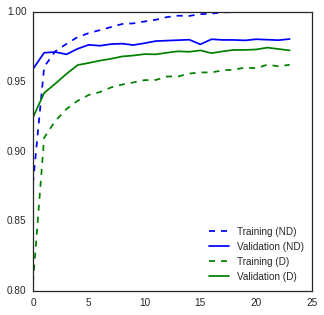

In [100]:
plt.figure(figsize=(5,5))
plt.plot(acc, linestyle='--', label='Training (ND)', color='b')
plt.plot(val, label='Validation (ND)', color='b')
plt.plot(dropout_acc, linestyle='--', label='Training (D)', color='g')
plt.plot(dropout_val, label='Validation (D)', color='g')
plt.legend(loc='lower right')
plt.ylim(0.8,1.0)
plt.show()

<h1>Convolutional Neural Networks</h1>

The column oriented parallel processing streams of the primate visual system prompted the development of convolutional neural networks. By convolving neural network with the input data, a single set of weights can be trained to extract common features throughout the image. For each pixel in our image, a value is generated that is the output of the neural network when centered on that pixel. This is a powerful technique for image processing.

<h2>Convolution</h2>

Convolution is a process by which one function of finite width is composed with another. In our case, for each pixel in the image, the kernel function being convolved with the image is evaluated for that pixel and any surrounding pixels it covers, the sum is taken over all of its values, and the result of that sum is returned as the new value for the initial pixel.

<img src="imgs/convolution.gif" alt="Dropout Network" style="width: 250px;"/>

Below we'll quickly show a few examples of convolution in image processing.

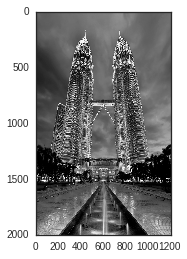

In [73]:
# Remove grid lines
sns.set_style("white")

patronas = spi.imread('imgs/patronas.jpg')
patronas_bw = np.ones(patronas.shape[:-1])-np.mean(patronas, axis=2)
patplot = plt.imshow(patronas_bw)

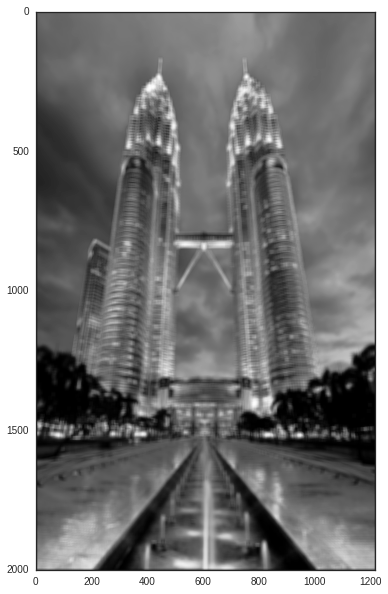

In [74]:
blur_kernel = np.ones((15,15))

plt.figure(figsize=(10,10))
patplot = plt.imshow(spi.convolve(patronas_bw, blur_kernel, mode='constant', cval=0.0))

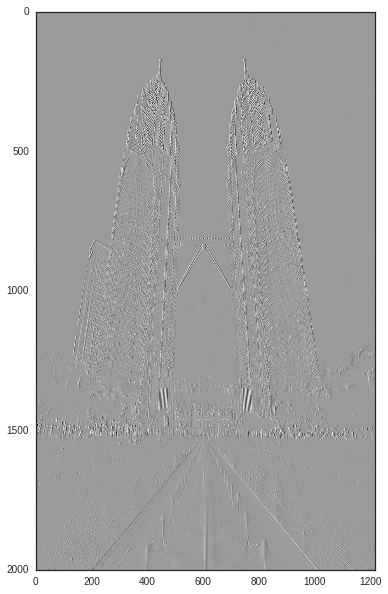

In [72]:
plt.figure(figsize=(10,10))
patplot = plt.imshow(spi.filters.sobel(patronas_bw))

Convolutional neural networks convolve the image with a network with a fixed number of output nodes. Each pixel therefore produces a number of outputs equal to the number of nodes in the convolutional layer. This causes rapid explosions in dimensionality, and must be managed somehow.

We can control dimensionality with a technique called max pooling, designed to loosely emulate the winner-take-all competitive inhibition observed in the brain. In a max pooling layer inputs are clustered into NxN groups, and only the maximum value is handed to the next layer. Thus a 2x2 max pooling layer reduces the size of the data by a factor of 4.

<img src="imgs/maxpool.jpg" alt="Max Pooling Layer" style="width: 400px;"/>

As an example, we'll load the 16 layer VGG16 convnet pre-trained on the ImageNet database, and ask it to label several images. This is a large, complex model the incorporates everything we've seen plus a new activation function, the rectified linear unit. This function is linear when values are positive, and always returns 0 when values are negative. It has been demonstrated to speed convergence with no loss in final accuracy or generalizability.

In [102]:
def preprocess(img):
    sp = spm.imresize(img, (224,224))
    sp = sp.astype('float32')
    sp[:,:,0] -= 103.939 # Subtract the mean RBG values of the ImageNet data set
    sp[:,:,1] -= 116.779
    sp[:,:,2] -= 123.68
    sp = sp.transpose((2,0,1))
    sp = np.expand_dims(sp, axis=0)
    return sp

def VGG_16(weights_path):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

model = VGG_16('weights/vgg16.hdf5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [22]:
with open('weights/labels.txt', 'r') as f:
    labels = f.read().splitlines()

The following examples show the top five predicted labels for the associated images, along with the confidence assigned to each. 

[(0.17179176211357117, 'pier'), (0.11650403589010239, 'thimble'), (0.06691896915435791, 'steel arch bridge'), (0.066427566111087799, 'screw'), (0.045644700527191162, 'solar dish, solar collector, solar furnace')]


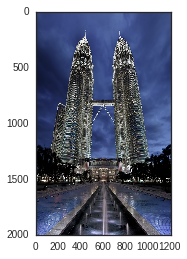

In [26]:
sp = preprocess(patronas)
predictions = model.predict(sp)
plt.imshow(patronas)
print(sorted(zip(predictions.squeeze(), labels),reverse=True)[:5])

[(0.10945373028516769, 'tiger, Panthera tigris'), (0.10204992443323135, 'Great Dane'), (0.051435332745313644, 'bull mastiff'), (0.050695545971393585, 'bluetick'), (0.049715150147676468, 'dalmatian, coach dog, carriage dog')]


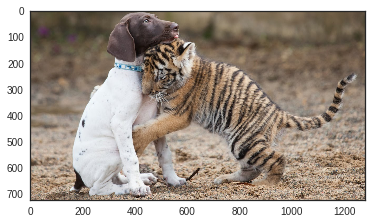

In [30]:
tiger_dog = spi.imread('imgs/tiger_dog.jpg')
sp = preprocess(tiger_dog)
predictions = model.predict(sp)
plt.imshow(tiger_dog)
print(sorted(zip(predictions.squeeze(), labels),reverse=True)[:5])

[(0.99571043252944946, 'lion, king of beasts, Panthera leo'), (0.00063334940932691097, 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'), (0.00038852656143717468, 'ox'), (0.00027684745145961642, 'brown bear, bruin, Ursus arctos'), (0.00024734623730182648, 'tiger, Panthera tigris')]


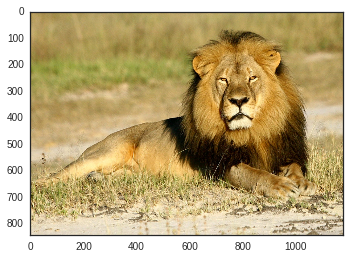

In [27]:
lion = spi.imread('imgs/lion.jpg')
sp = preprocess(lion)
predictions = model.predict(sp)
plt.imshow(lion)
print(sorted(zip(predictions.squeeze(), labels),reverse=True)[:5])

[(0.96927320957183838, 'airliner'), (0.022400576621294022, 'wing'), (0.0028783364687114954, 'space shuttle'), (0.0017280719475820661, 'warplane, military plane'), (0.0017219685250893235, 'airship, dirigible')]


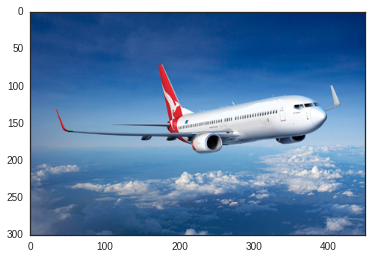

In [31]:
plane = spi.imread('imgs/airplane.jpg')
sp = preprocess(plane)
predictions = model.predict(sp)
plt.imshow(plane)
print(sorted(zip(predictions.squeeze(), labels),reverse=True)[:5])

In [42]:
def web_predict(URL):
    web_img = Image.open(StringIO(requests.get(URL).content))
    sp = preprocess(web_img)
    predictions = model.predict(sp)
    plt.imshow(web_img)
    print(sorted(zip(predictions.squeeze(), labels),reverse=True)[:5])

Having defined the function above, you can now explore how the VGG16 network classifies images drawn from the web. We can quickly see it generates unexpected results for images that aren't represented 

[(0.89051872491836548, 'fountain'), (0.014861552976071835, 'goblet'), (0.0073529509827494621, 'beer glass'), (0.0069143129512667656, 'water bottle'), (0.0068005467765033245, 'wine bottle')]


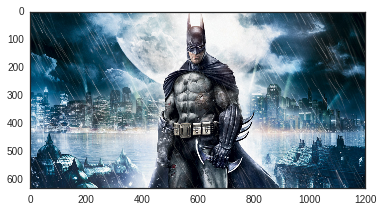

In [43]:
web_predict("http://www.studiocity-macau.com/uploads/images/SC/Entertainment/Batman/batman_share.jpg")

[(0.23846599459648132, 'whippet'), (0.16218060255050659, 'wallaby, brush kangaroo'), (0.061153601855039597, 'Weimaraner'), (0.029129087924957275, 'bluetick'), (0.025986736640334129, 'Madagascar cat, ring-tailed lemur, Lemur catta')]


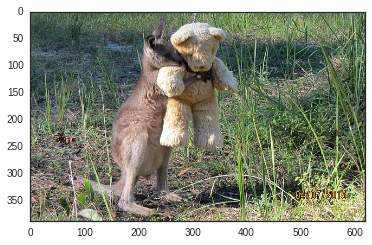

In [44]:
web_predict("http://i.telegraph.co.uk/multimedia/archive/03400/Doodlebug_3400501b.jpg")

[(0.25857061147689819, 'spider monkey, Ateles geoffroyi'), (0.16840359568595886, 'gazelle'), (0.077751971781253815, 'Madagascar cat, ring-tailed lemur, Lemur catta'), (0.073952898383140564, 'wallaby, brush kangaroo'), (0.067129768431186676, 'impala, Aepyceros melampus')]


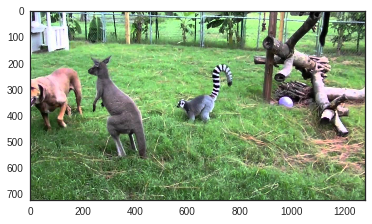

In [45]:
web_predict("https://i.ytimg.com/vi/S6uQgFxnvwE/maxresdefault.jpg")